In [342]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from abc import ABC, abstractmethod
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder


- Load the dataset
- Create floor column --> add plot in EDA
- Drop the columns useless: orientation, num_supermarkets, door

In [343]:
class DataLoader():
    def __init__(self, path, columns_to_drop):
        self.path = path
        self.columns_to_drop = columns_to_drop
    
    def load_and_split(self):
        df = pd.read_csv(self.path)
        df['floor'] = df['door'].str.extract(r'(\d{1,2})º')
        df = df.drop(columns = self.columns_to_drop)
        df_train, df_test = train_test_split(df, test_size=0.3, random_state=10)
        return df_train, df_test

Numerical Columns:

- square_meters imputer
- num_rooms fill with square_meters, neighborhood
- num_baths fill with num_rooms
- year_built fill with num_rooms, square_meters, neighborhood
- floor
- num_crimes

In [344]:
class NumericalFeaturesDataCleaner:
    def __init__(self, df):
        self.df = df

    def impute_square_meters(self):
        #Replace negative values with nan and then impute with knn and randomforest regressor
        self.df['square_meters'] = self.df['square_meters'].apply(lambda x: np.nan if x < 0 else x)
        # imputer = KNNImputer(n_neighbors=5)
        #self.df['square_meters_knn'] = imputer.fit_transform(self.df[['square_meters']])
        imputer_2 = IterativeImputer(estimator=RandomForestRegressor(), random_state=42)
        self.df['square_meters'] = imputer_2.fit_transform(self.df[['square_meters']])
        
    def impute_num_rooms(self):
        # Cambia valores mayores a 10 en 'num_rooms' a NaN
        self.df['num_rooms'] = self.df['num_rooms'].apply(lambda x: np.nan if x > 10 else x)

        # Imputar solo los nulos en 'num_rooms' basados en 'neighborhood' y en rangos de 'square_meters'
        imputed_rooms = self.df.groupby(['neighborhood', pd.cut(self.df['square_meters'], bins=4)])['num_rooms'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else self.df['num_rooms'].mode().iloc[0])
        # Combinar el resultado de imputación solo en posiciones nulas
        self.df['num_rooms'] = self.df['num_rooms'].combine_first(imputed_rooms)
        self.df['num_rooms'] = self.df['num_rooms'].fillna(self.df['num_rooms'].mode()[0])

    def impute_num_baths(self):
        # Usa la moda de 'num_baths' condicionada por 'num_rooms'
        self.df['num_baths'] = self.df.groupby(['num_rooms', 'square_meters'])['num_baths'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else 1)

    def impute_year_built(self):
        # Usa la moda de 'year_built' basada en 'num_rooms', 'square_meters', y 'neighborhood'
        imputed_years = self.df.groupby(['neighborhood', 'num_rooms', pd.cut(self.df['square_meters'], bins=4)])['year_built'] \
                                     .transform(lambda x: x.mean() )
        self.df['year_built'] = self.df['year_built'].combine_first(imputed_years)
        self.df['year_built'] = self.df['year_built'].fillna(self.df['year_built'].mean())

    def impute_floor(self):
        # Convierte 'floor' a numérico
        self.df['floor'] = pd.to_numeric(self.df['floor'], errors='coerce')
        imputer_2 = IterativeImputer(estimator=RandomForestRegressor(), random_state=32)
        self.df['floor'] = imputer_2.fit_transform(self.df[['floor']])
        self.df['floor'] = self.df[['floor']].round()
    
    def impute_num_crimes(self):
        self.df['num_crimes'] = pd.to_numeric(self.df['num_crimes'], errors='coerce')
        imputer_2 = IterativeImputer(estimator=RandomForestRegressor(), random_state=42)
        self.df['num_crimes'] = imputer_2.fit_transform(self.df[['num_crimes']]).round()
    
    
    def process_all(self):
        self.impute_square_meters()
        self.impute_num_rooms()
        self.impute_num_baths()
        self.impute_year_built()
        self.impute_floor()
        self.impute_num_crimes()
        return self.df
    
    def return_results(self):
        return self.df


Categorical Features:

- is_furnished
- has_pool
- has_ac
- accepts_pets

In [345]:
class CategoricalFeaturesDataCleaner:
    np.random.seed(43)
    def __init__(self, df, columns):
        self.df = df
        self.columns = columns

    def impute_categorical_randomly(self):
        for c in self.columns:
        # self.df[f'{self.column}_random'] = self.df[self.column].fillna(pd.Series(np.random.choice([0, 1], size=self.df[self.column].isnull().sum())))
            self.df[f'{c}_random'] = self.df[c].fillna(np.random.choice([0, 1]))

    def impute_is_furnished(self):
        self.df['is_furnished'] = self.df['is_furnished'].fillna(self.df['is_furnished'].mode()[0])
    
    def impute_has_ac(self):
        self.df['has_ac'] = self.df['has_ac'].fillna(self.df['has_ac'].mode()[0])
    
    def impute_has_pool(self):
        self.df['has_pool'] = self.df['has_pool'].fillna(self.df['has_pool'].mode()[0])
    
    def impute_accepts_pets(self):
        self.df['accepts_pets'] = self.df['accepts_pets'].fillna(self.df['accepts_pets'].mode()[0])
      

    def impute_neighborhodd(self):
        self.df['neighborhood'] = self.df['neighborhood'].fillna(self.df['neighborhood'].mode()[0])

    def process_all(self):
        self.impute_categorical_randomly()
        self.impute_is_furnished()
        self.impute_has_ac()
        self.impute_has_pool()
        self.impute_accepts_pets()
        self.impute_neighborhodd()
        return self.df

    

### Create Dummies
----

In [346]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

class CreateDummies:
    def __init__(self, df, ordinal_columns, categorical_columns):
        self.df = df
        self.ordinal_columns = ordinal_columns
        self.categorical_columns = categorical_columns

    def transformer_get_dummies(self):
        # Generar dummies para las columnas categóricas
        self.df  = pd.get_dummies(self.df, columns=self.categorical_columns, drop_first=True)

    def transformer_ordinalencoder(self):
        encoder = OrdinalEncoder()
        # Transformar y crear DataFrame con columnas ordinales codificadas
        encoded_variable = encoder.fit_transform(self.df[self.ordinal_columns])
        df_encoded = pd.DataFrame(encoded_variable, columns=self.ordinal_columns).reset_index(drop=True)

        # Eliminar las columnas ordinales originales y concatenar
        self.df = self.df.drop(columns=self.ordinal_columns).reset_index(drop=True)
        self.df = pd.concat([self.df, df_encoded], axis=1)
    
    def get_dummies(self):
        self.df = pd.get_dummies(self.df, columns=['neighborhood'], drop_first=True)
    
    def process_all(self):
        self.transformer_get_dummies()
        self.transformer_ordinalencoder()
        self.get_dummies()
        return self.df


- Load the dataset
- Create floor column --> add plot in EDA
- Drop the columns useless: orientation, num_supermarkets, door

### Feature Engineering
---

In [347]:
def year_group(df):
    if 'year' in df.columns:
        df['year_group'] = df['year'].apply(lambda x: 1 if x <= 1970 else (2 if x <= 1990 else 3))
    return df

def safety_level(df):
    if 'num_crimes' in df.columns: 
        df['safety_level'] = df['num_crimes'].apply(lambda x: 1 if x == 0 else 0)
    return df

def neigh_crime(df):
    neighborhood_columns = [col for col in df.columns if 'neigh' in col]
    for col in neighborhood_columns:
        df[f'{col}_crime'] = df[col] * df['safety_level']
    return df

def has_ac_pool(df):
    if 'has_pool' in df.columns:
        df['has_ac_pool'] = df['has_ac'] * df['has_pool']
    return df

def square_met_2(df):
    if 'square_meters' in df.columns:
        df['square_met_2'] = df['square_meters'] ** 2
    return df


### Trials for Models
----

Load data and split

In [348]:
data_loader = DataLoader(path='predicting-apartment-prices-in-barcelona-2024/train.csv', columns_to_drop=['orientation', 'num_supermarkets', 'door'])
df_train, df_test = data_loader.load_and_split()

Fillna

In [349]:
df_train_transformer = NumericalFeaturesDataCleaner(df_train)
df_train = df_train_transformer.process_all()
df_test_transformer = NumericalFeaturesDataCleaner(df_test)
df_test = df_test_transformer.process_all()

/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_7657/4161648832.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imputed_rooms = self.df.groupby(['neighborhood', pd.cut(self.df['square_meters'], bins=4)])['num_rooms'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else self.df['num_rooms'].mode().iloc[0])
/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_7657/4161648832.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imputed_years = self.df.groupby(['neighborhood', 'num_rooms', pd.cut(self.df['square_meters'], bins=4)])['year_built'] \
/var/folders/fz/1mp_qssx1z546qc9z

Create new features and dummies

In [350]:
categorical_columns = ['is_furnished', 'has_ac', 'has_pool', 'accepts_pets', 'neighborhood']

df_train_transformer_cat = CategoricalFeaturesDataCleaner(df_train, categorical_columns)
df_train = df_train_transformer_cat.process_all()

df_test_transformer_cat = CategoricalFeaturesDataCleaner(df_test, categorical_columns)
df_test = df_test_transformer_cat.process_all()

#create neighborhood dummies
df_train = pd.get_dummies(df_train, columns=['neighborhood'], drop_first = True)
df_test = pd.get_dummies(df_test, columns=['neighborhood'], drop_first = True)

df_train = df_train.drop(columns=['neighborhood'], errors='ignore')
df_test = df_test.drop(columns=['neighborhood'], errors='ignore')

/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_7657/3942907821.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df['is_furnished'] = self.df['is_furnished'].fillna(self.df['is_furnished'].mode()[0])
/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_7657/3942907821.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df['has_ac'] = self.df['has_ac'].fillna(self.df['has_ac'].mode()[0])
/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_7657/3942907821.py:19: FutureWarning: Downcasting object dtype arrays on .filln

In [351]:
# Suponiendo que df_train es tu DataFrame
functions_to_apply = [year_group, safety_level, neigh_crime, has_ac_pool, square_met_2]

for func in functions_to_apply:
    df_train = func(df_train)  # Aplica cada función al DataFrame

for func in functions_to_apply:
    df_train = func(df_test) 

In [352]:
df_train.columns

Index(['id', 'num_rooms', 'num_baths', 'square_meters', 'year_built',
       'is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets',
       'price', 'floor', 'is_furnished_random', 'has_ac_random',
       'has_pool_random', 'accepts_pets_random', 'neighborhood_random',
       'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta',
       'neighborhood_Les Cors', 'neighborhood_Nou Barris',
       'neighborhood_Sant Andreu', 'neighborhood_Sant Martí',
       'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi',
       'safety_level', 'neighborhood_random_crime',
       'neighborhood_Eixample_crime', 'neighborhood_Gràcia_crime',
       'neighborhood_Horta_crime', 'neighborhood_Les Cors_crime',
       'neighborhood_Nou Barris_crime', 'neighborhood_Sant Andreu_crime',
       'neighborhood_Sant Martí_crime', 'neighborhood_Sants_crime',
       'neighborhood_Sarrià-Sant Gervasi_crime', 'has_ac_pool',
       'square_met_2'],
      dtype='object')

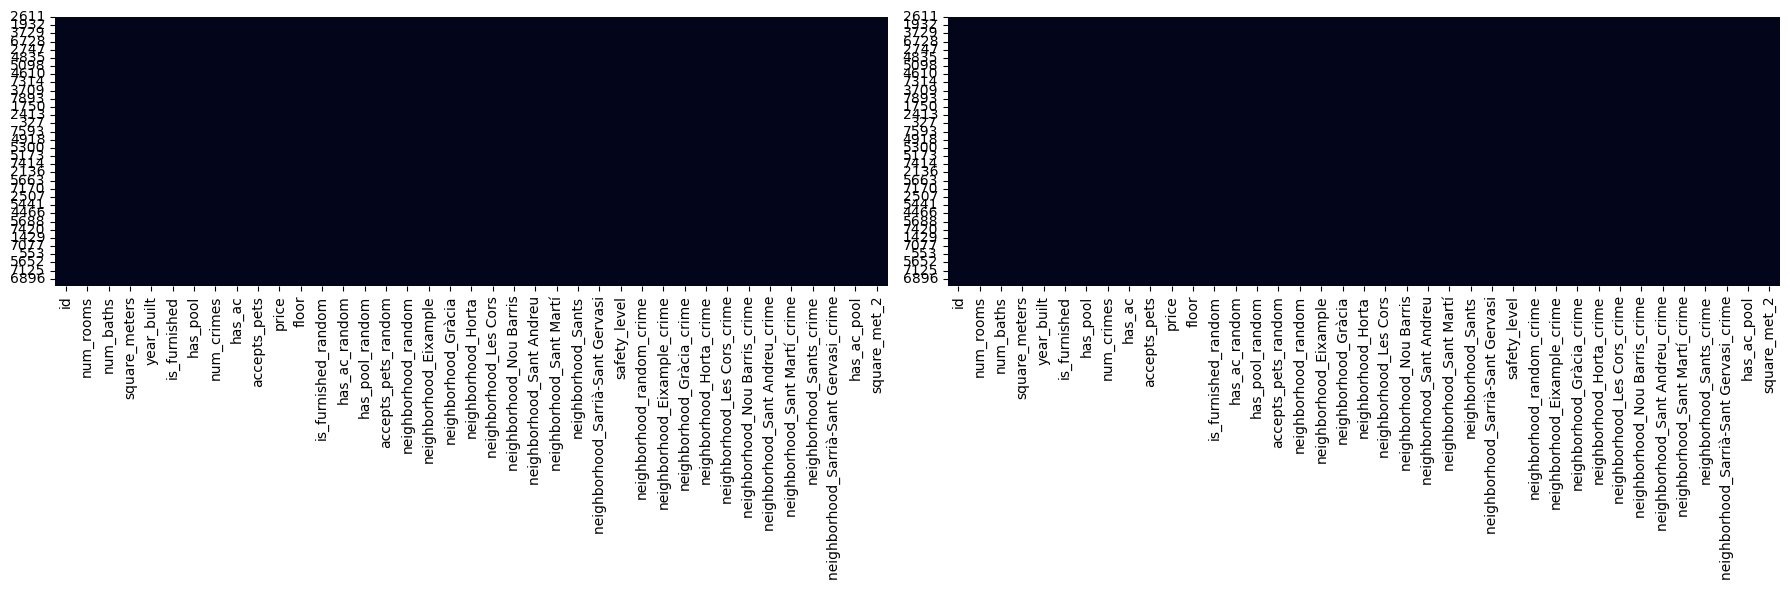

In [353]:
# Crear una figura con tres subplots en una fila
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(df_train.isnull(), cbar=False, ax=axes[0])
sns.heatmap(df_test.isnull(), cbar=False, ax=axes[1])

plt.tight_layout()
plt.show()

In [354]:
class LinearModel():
    def __init__(self, features_columns, target_column, hyperparameters: dict = None):
        self.features_columns = features_columns
        self.target_column = target_column
        self.model_params = hyperparameters if hyperparameters else {}
        self.model = LinearRegression()

    def train_model(self, df):
        X = df[self.features_columns]
        y = df[self.target_column]
        
        # Escalar las características
        scale = StandardScaler()
        X_scaled = scale.fit_transform(X)
        
        self.model.fit(X_scaled, y)
        self.scaler = scale  # Guardar el scaler para usarlo en predicciones

    def predict_model(self, df):
        X = df[self.features_columns]
        X_scaled = self.scaler.transform(X)  # Escalar las características
        return self.model.predict(X_scaled)

    def evaluate_model(self, df):
        X = df[self.features_columns]
        y = df[self.target_column]
        
        # Predecir y calcular MSE
        y_pred = self.predict_model(df)
        mse = mean_squared_error(y, y_pred).round()
        return mse


In [355]:
from sklearn.linear_model import Ridge

from sklearn.model_selection import GridSearchCV


class RidgeModel():
    def __init__(self, features_columns, target_column):
        self.features_columns = features_columns
        self.target_column = target_column
        self.model = Ridge()  # Modelo inicial sin hiperparámetros

    def train_model(self, df, param_grid):
        X = df[self.features_columns]
        y = df[self.target_column]

        # Escalar las características
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        # GridSearchCV para encontrar los mejores hiperparámetros
        grid_search = GridSearchCV(self.model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_scaled, y)

        # Guardar el mejor modelo y los mejores parámetros
        self.model = grid_search.best_estimator_
        self.best_params = grid_search.best_params_

    def predict_model(self, df):
        X = df[self.features_columns]
        X_scaled = self.scaler.transform(X)  # Escalar las características
        return self.model.predict(X_scaled)

    def evaluate_model(self, df):
        X = df[self.features_columns]
        y = df[self.target_column]

        # Predecir y calcular MSE
        y_pred = self.predict_model(df)
        mse = mean_squared_error(y, y_pred)
        return mse

In [357]:
features_columns = ['num_rooms', 'num_baths', 'square_meters', 'year_built',
       'is_furnished_random', 'has_pool_random', 'accepts_pets_random','num_crimes', 'floor',
       'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta',
       'neighborhood_Les Cors', 'neighborhood_Nou Barris',
       'neighborhood_Sant Andreu', 'neighborhood_Sant Martí',
       'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi',
       'safety_level', 'neighborhood_Eixample_crime', 'neighborhood_Gràcia_crime',
       'neighborhood_Horta_crime', 'neighborhood_Les Cors_crime',
       'neighborhood_Nou Barris_crime', 'neighborhood_Sant Andreu_crime',
       'neighborhood_Sant Martí_crime', 'neighborhood_Sants_crime',
       'neighborhood_Sarrià-Sant Gervasi_crime', 'has_ac_pool',
       'square_met_2']
target_column = 'price'
hyperparameters = None
model = LinearModel(features_columns, target_column, hyperparameters)
model.train_model(df_train)
predictions = model.predict_model(df_test)
# Evaluar el modelo
mse = model.evaluate_model(df_test)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 30169.0


In [358]:
# Definir el rango de hiperparámetros para GridSearch
param_grid = {
    'alpha': [0.1, 0.2, 0.3, 0.9,1,2, 3,4,5,10.0,11,12,13,14,16, 20, 21, 25, 40, 44, 45,50]  # Prueba diferentes valores de alpha
}

# Crear una instancia del modelo
ridge_model = RidgeModel(features_columns, target_column)

# Entrenar el modelo usando GridSearch
ridge_model.train_model(df_train, param_grid)

# Realizar predicciones en el conjunto de test
predictions = ridge_model.predict_model(df_test)

# Evaluar el modelo
mse = ridge_model.evaluate_model(df_test)

# Imprimir resultados
print("Mejores parámetros:", ridge_model.best_params)
print("MSE:", mse)

Mejores parámetros: {'alpha': 1}
MSE: 30169.168418484554


In [359]:
features_columns_2 = ['square_meters', 'num_crimes', 'year_built',
        'has_ac', 'floor', 'safety_level',
       'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta',
       'neighborhood_Les Cors', 'neighborhood_Nou Barris',
       'neighborhood_Sant Andreu', 'neighborhood_Sant Martí',
       'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi',
        'neighborhood_Eixample_crime', 'neighborhood_Gràcia_crime',
       'neighborhood_Horta_crime', 'neighborhood_Les Cors_crime',
       'neighborhood_Nou Barris_crime', 'neighborhood_Sant Andreu_crime',
       'neighborhood_Sant Martí_crime', 'neighborhood_Sants_crime',
       'neighborhood_Sarrià-Sant Gervasi_crime', 'has_ac_pool']
target_column = 'price'
hyperparameters = None
model = LinearModel(features_columns, target_column, hyperparameters)
model.train_model(df_train)
predictions = model.predict_model(df_test)
# Evaluar el modelo
mse = model.evaluate_model(df_test)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 30169.0


In [367]:
features_3 = ['num_rooms', 'num_baths', 'square_meters', 'year_built',
       'is_furnished', 'has_pool', 'accepts_pets','num_crimes', 'floor',
       'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta',
       'neighborhood_Les Cors', 'neighborhood_Nou Barris',
       'neighborhood_Sant Andreu', 'neighborhood_Sant Martí',
       'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi',
       'safety_level', 'neighborhood_Eixample_crime', 'neighborhood_Gràcia_crime',
       'neighborhood_Horta_crime', 'neighborhood_Les Cors_crime',
       'neighborhood_Nou Barris_crime', 'neighborhood_Sant Andreu_crime',
       'neighborhood_Sant Martí_crime', 'neighborhood_Sants_crime',
       'neighborhood_Sarrià-Sant Gervasi_crime', 'has_ac_pool']

In [392]:
features_4 = ['num_rooms', 'num_baths', 'square_meters', 'year_built',
       'is_furnished', 'has_pool', 'accepts_pets','num_crimes', 'floor',
       'has_ac_pool']
features_5 = ['num_rooms', 'num_baths', 'square_meters',
       'num_crimes', 'floor',
       'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta',
       'neighborhood_Les Cors', 'neighborhood_Nou Barris',
       'neighborhood_Sant Andreu', 'neighborhood_Sant Martí',
       'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi',
       'safety_level', 'neighborhood_Eixample_crime', 'neighborhood_Gràcia_crime',
       'neighborhood_Horta_crime', 'neighborhood_Les Cors_crime',
       'neighborhood_Nou Barris_crime', 'neighborhood_Sant Andreu_crime',
       'neighborhood_Sant Martí_crime', 'neighborhood_Sants_crime',
       'neighborhood_Sarrià-Sant Gervasi_crime']


In [ ]:
features_4 = ['num_rooms', 'num_baths', 'square_meters', 'year_built',
       'is_furnished', 'has_pool', 'accepts_pets','num_crimes', 'floor',
       'has_ac_pool']

In [360]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

class NonLinearModel():
    def __init__(self, model_class, features_columns, target_column):
        self.model_class = model_class
        self.features_columns = features_columns
        self.target_column = target_column
        self.model = None
        self.scaler = None
        self.random_seed = 42

    def train_model(self, df, param_grid):
        X = df[self.features_columns]
        y = df[self.target_column]

        # Escalar las características
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        # GridSearchCV para encontrar los mejores hiperparámetros
        grid_search = GridSearchCV(self.model_class(random_state=self.random_seed), param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_scaled, y)

        # Guardar el mejor modelo y los mejores parámetros
        self.model = grid_search.best_estimator_
        self.best_params = grid_search.best_params_

    def predict_model(self, df):
        X = df[self.features_columns]
        X_scaled = self.scaler.transform(X)  # Escalar las características
        return self.model.predict(X_scaled)

    def evaluate_model(self, df):
        X = df[self.features_columns]
        y = df[self.target_column]

        # Predecir y calcular MSE
        y_pred = self.predict_model(df)
        mse = mean_squared_error(y, y_pred)
        return mse



Evaluating Decision Tree...
Mejores parámetros para Decision Tree: {'max_depth': 5, 'min_samples_split': 2}
MSE para Decision Tree: 29899.35707206229

Evaluating Random Forest...
Mejores parámetros para Random Forest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
MSE para Random Forest: 28048.95001655909

Evaluating Gradient Boosting...
Mejores parámetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MSE para Gradient Boosting: 27794.520626182544

El mejor modelo es: Gradient Boosting con un MSE de 27794.520626182544


In [393]:
import xgboost as xgb
param_grids = {
    DecisionTreeRegressor: {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    RandomForestRegressor: {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    GradientBoostingRegressor: {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Lista de modelos no lineales a probar
models = {
    'Decision Tree': DecisionTreeRegressor,
    'Random Forest': RandomForestRegressor,
    'Gradient Boosting': GradientBoostingRegressor
}

# Evaluar cada modelo y guardar el mejor
best_models = {}
best_mse = np.inf
best_model_name = None

for model_name, model_class in models.items():
    print(f"\nEvaluating {model_name}...")
    param_grid = param_grids[model_class]  # Usar el modelo como clave
    model_instance = NonLinearModel(model_class, features_5, target_column)
    
    # Entrenar el modelo usando GridSearch
    model_instance.train_model(df_train, param_grid)

    # Evaluar el modelo
    mse = model_instance.evaluate_model(df_test)

    # Almacenar el mejor modelo basado en el MSE
    if mse < best_mse:
        best_mse = mse
        best_model_name = model_name
        best_model = model_instance
    
    # Almacenar el modelo y sus mejores parámetros
    best_models[model_name] = (model_instance.model, model_instance.best_params, mse)
    print(f"Mejores parámetros para {model_name}:", model_instance.best_params)
    print(f"MSE para {model_name}:", mse)


# Imprimir el mejor modelo general
print(f"\nEl mejor modelo es: {best_model_name} con un MSE de {best_mse}")


Evaluating Decision Tree...
Mejores parámetros para Decision Tree: {'max_depth': 5, 'min_samples_split': 2}
MSE para Decision Tree: 30008.769187109476

Evaluating Random Forest...
Mejores parámetros para Random Forest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
MSE para Random Forest: 28297.295691209212

Evaluating Gradient Boosting...
Mejores parámetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MSE para Gradient Boosting: 28065.67514942512

El mejor modelo es: Gradient Boosting con un MSE de 28065.67514942512


### Testing dataset
----


In [385]:
df = pd.read_csv('predicting-apartment-prices-in-barcelona-2024/test.csv')
df['floor'] = df['door'].str.extract(r'(\d{1,2})º')
df = df.drop(columns = ['orientation', 'num_supermarkets', 'door'], axis=1)

In [386]:
df_transformer = NumericalFeaturesDataCleaner(df)
df = df_transformer.process_all()

/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_7657/4161648832.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imputed_rooms = self.df.groupby(['neighborhood', pd.cut(self.df['square_meters'], bins=4)])['num_rooms'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else self.df['num_rooms'].mode().iloc[0])
/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_7657/4161648832.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imputed_years = self.df.groupby(['neighborhood', 'num_rooms', pd.cut(self.df['square_meters'], bins=4)])['year_built'] \


In [387]:
categorical_columns = ['is_furnished', 'has_ac', 'has_pool', 'accepts_pets', 'neighborhood']

df_transformer_cat = CategoricalFeaturesDataCleaner(df, categorical_columns)
df = df_transformer_cat.process_all()

#create neighborhood dummies
df = pd.get_dummies(df, columns=['neighborhood'], drop_first = True)
df = df.drop(columns=['neighborhood'], errors='ignore')


/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_7657/3942907821.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df['is_furnished'] = self.df['is_furnished'].fillna(self.df['is_furnished'].mode()[0])
/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_7657/3942907821.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df['has_ac'] = self.df['has_ac'].fillna(self.df['has_ac'].mode()[0])
/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_7657/3942907821.py:19: FutureWarning: Downcasting object dtype arrays on .filln

In [388]:
# Suponiendo que df_train es tu DataFrame
functions_to_apply = [year_group, safety_level, neigh_crime, has_ac_pool, square_met_2]
for func in functions_to_apply:
    df = func(df)

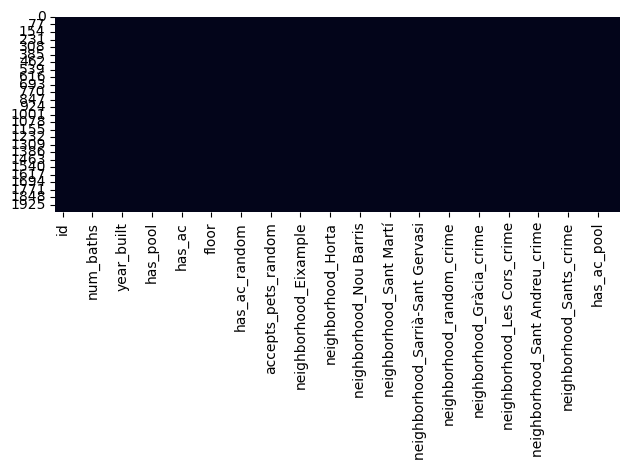

In [389]:
# Crear una figura con tres subplots en una fila

sns.heatmap(df.isnull(), cbar=False)

plt.tight_layout()
plt.show()

In [390]:
features_4

['num_rooms',
 'num_baths',
 'square_meters',
 'year_built',
 'is_furnished',
 'has_pool',
 'accepts_pets',
 'num_crimes',
 'floor',
 'has_ac_pool']

In [394]:
features_columns = ['num_rooms', 'num_baths', 'square_meters', 'year_built',
       'is_furnished_random', 'has_pool_random', 'accepts_pets_random','num_crimes', 'floor',
       'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta',
       'neighborhood_Les Cors', 'neighborhood_Nou Barris',
       'neighborhood_Sant Andreu', 'neighborhood_Sant Martí',
       'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi',
       'safety_level', 'neighborhood_Eixample_crime', 'neighborhood_Gràcia_crime',
       'neighborhood_Horta_crime', 'neighborhood_Les Cors_crime',
       'neighborhood_Nou Barris_crime', 'neighborhood_Sant Andreu_crime',
       'neighborhood_Sant Martí_crime', 'neighborhood_Sants_crime',
       'neighborhood_Sarrià-Sant Gervasi_crime', 'has_ac_pool',
       'square_met_2']
# Generar predicciones finales en el conjunto de test sin la variable objetivo
df['price'] = best_model.predict_model(df[features_5])

# Crear un DataFrame con las predicciones finales y el ID
predictions_output = df[['id', 'price']]
predictions_output.to_csv('predictions_5.csv', index=False)
print(predictions_output)

        id        price
0     6253  1420.698250
1     4685  1073.074237
2     1732   985.412725
3     4743  1293.352757
4     4522  1094.410739
...    ...          ...
1995  6413  1060.577394
1996  8286  1232.095127
1997  7854  1230.398101
1998  1096  1275.735141
1999  6930   840.299659

[2000 rows x 2 columns]
